##Install Required Libraries

In [1]:
!pip install ultralytics
!pip install opencv-python-headless
!pip install deep_sort_realtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

##Upload Model and Video

In [ ]:
from google.colab import files

print("📁 Upload YOLOv11 model (.pt file):")
model_upload = files.upload()

print("🎥 Upload your 15-second video (15sec_input_720p.mp4):")
video_upload = files.upload()

## Load YOLO Model

In [2]:
from ultralytics import YOLO

model = YOLO("/content/best (2).pt")
print(f"✅ Model '{'/content/best (2).pt'}' loaded successfully!")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Model '/content/best (2).pt' loaded successfully!


## Initialize DeepSORT Tracker

In [3]:
from deep_sort_realtime.deepsort_tracker import DeepSort
tracker = DeepSort(max_age=30)

##Run Detection + Tracking and Display Results


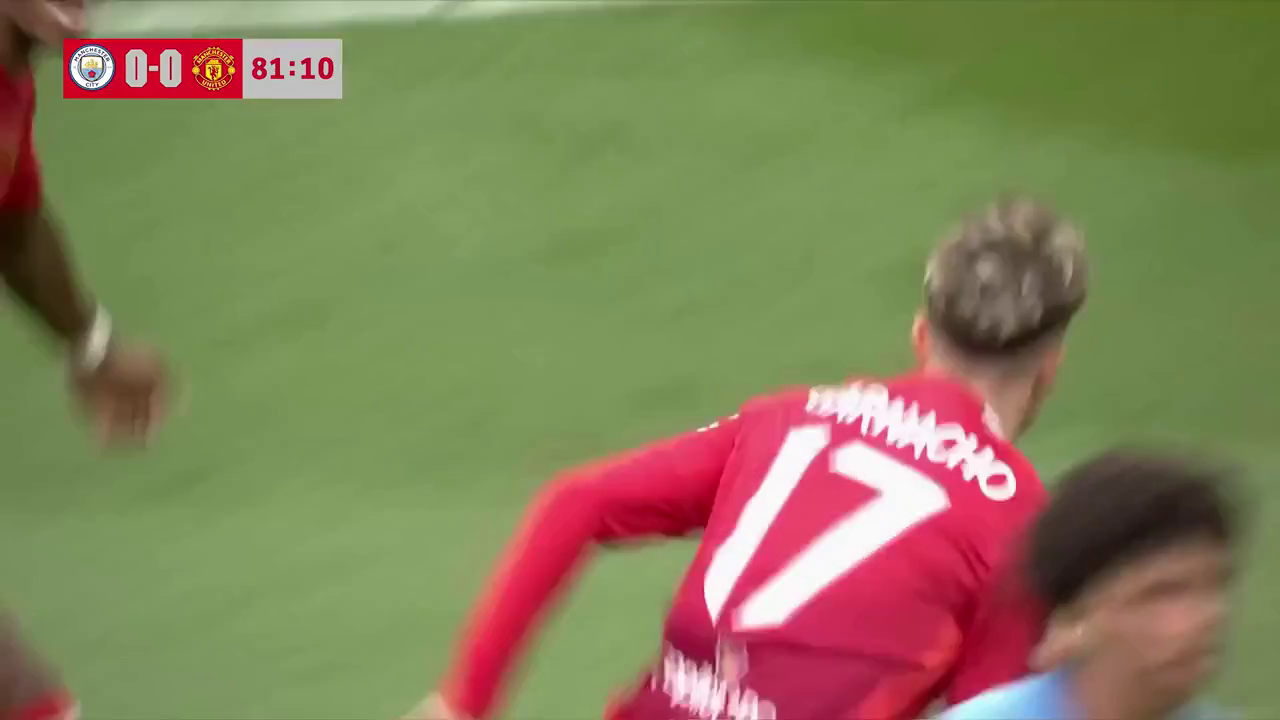

In [4]:
import cv2
from IPython.display import display, clear_output
from google.colab.patches import cv2_imshow

video_path = "/content/15sec_input_720p.mp4"
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)[0]

    detections = []
    for box in results.boxes.data.tolist():
        x1, y1, x2, y2, score, cls = box
        if int(cls) == 0:  # Assuming 'player' is class 0
            detections.append(([x1, y1, x2 - x1, y2 - y1], score, 'player'))

    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        ltrb = track.to_ltrb()
        x1, y1, x2, y2 = map(int, ltrb)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(frame, f"ID: {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    clear_output(wait=True)
    cv2_imshow(frame)

cap.release()
cv2.destroyAllWindows()


## Save the Output Video

In [5]:

cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

out = cv2.VideoWriter('tracked_output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Restart from beginning

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)[0]
    detections = []
    for box in results.boxes.data.tolist():
        x1, y1, x2, y2, score, cls = box
        if int(cls) == 0:
            detections.append(([x1, y1, x2 - x1, y2 - y1], score, 'player'))

    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        ltrb = track.to_ltrb()
        x1, y1, x2, y2 = map(int, ltrb)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(frame, f"ID: {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    out.write(frame)

cap.release()
out.release()
print("🎬 Tracked video saved as 'tracked_output.mp4'")



0: 384x640 1 ball, 16 players, 2 referees, 67.0ms
Speed: 2.1ms preprocess, 67.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 players, 2 referees, 65.2ms
Speed: 2.3ms preprocess, 65.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 64.1ms
Speed: 2.2ms preprocess, 64.1ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 2 referees, 54.6ms
Speed: 2.1ms preprocess, 54.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 2 referees, 37.5ms
Speed: 2.4ms preprocess, 37.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 37.5ms
Speed: 2.3ms preprocess, 37.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 2 referees, 36.9ms
Speed: 2.3ms preprocess, 36.9ms inference, 1.6ms postprocess per image at sha